# Sustainability reports analysis

# Introduzione

L'obiettivo della repository è quello di estrarre informazioni sui bilanci di sostenibilitò delle aziende italiane pubblicati nell'anno 2018.

# Processo
 
Il processo per ottenere l'indice da analizzare è così composto:

1. processing di un file csv contentente siti e web e link presenti su essi
2. download dei file ritenuti utili all'analisi
3. estrazione del testo dai file scaricati
4. indicizzazione elasticsearch con le informazioni trovate sulle aziende e delle entità estratte dai testi dei documenti

# Processing link csv

Il punto di partenza è costituito da un csv con un insieme di coppie __website__ , __pdf_dump__:

- Il primo è il dominio del sito web di cui sono stati estratti i pdf.
- Il secondo è una lista di oggetti che contengono:

    1. Url della pagina a cui è stato trovato il link
    2. Url del file pdf in questione
    3. Anchor del file nella pagina
    4. Sequenza di blocchi html in cui si trova l'anchor
    
L'obbiettivo della prima fase è quello di estrarre dal totale dei link solo quelli utili, ovvero quelli che possono rappresentare un probabile bilancio di sostenibilità 2018.

Prendiamo per semplicità un insieme ridotto e applichiamo il processo in questione.

In [1]:
import pandas as pd

csv_source = "samples/small.csv"

data = pd.read_csv(csv_source) 
data.head()

,domain,pdf_dump
0,www.iav.com,"[{""sourcePageUrl"":""https://www.iav.com/en/comp..."
1,www.enel.com,"[{""sourcePageUrl"":""https://www.enel.com/es/his..."
2,www.icpaoloterzo.edu.it,"[{""sourcePageUrl"":""https://www.icpaoloterzo.ed..."
3,www.cartadaformaggio.it,"[{""sourcePageUrl"":""http://www.cartadaformaggio..."
4,www.cartadimilano.org,"[{""sourcePageUrl"":""http://www.cartadimilano.or..."


La procedura legge da un file di input e restituisce un dizionario contenente:

__website__: lista di __link__, con url e score.

In [2]:
from csv_links_processing import find_reports, get_stats
import json

csv_dest = "samples/dest.csv"
stats_dest = "samples/stats.csv"

links, stats = find_reports(csv_source)

print(json.dumps(links, indent = 2), end = '\n\n')
print(get_stats(stats).replace(',', ': '))

{
  "www.iav.com": [
    {
      "url": "https://www.iav.com/app/uploads/2019/02/IAV_Sustainability_Report_2018.pdf",
      "score": 60
    }
  ],
  "www.enel.com": [
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/bilanci-annuali/2018/bilancio-di-sostenibilita-2018.pdf",
      "score": 60
    },
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/annual-financial-report/2018/sustainability-report-2018.pdf",
      "score": 60
    }
  ]
}

metric: value
Total websites: 5
Websites who published: 2
Published percentage: 40.000000
Total links: 65
Probable sustainability pdfs links: 3
Useful pdfs percentage: 4.615385
Average depth: 2.000000
Pdfs in homepage: 1


## Valutazione link

Il valore dello score dipende dalla funzione __evaluate__ , che valuta la pertinenza di un link in merito al tema della sostenibilità.

La funzione nello specifico considera il filename, l'url dal quale è stato raggiunto il file e l'anchor, computa uno score, il numero di occorenze di un "anno", in questo caso il 2018, e assegna un valore booleano al link.

Nel caso di esempio, e nella versione finale è utilizzata la seguente condizione:

$$tsh \,= \,40$$
$$ \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

In [3]:
from csv_links_processing import evaluate

ll = [
    {
        'pdfUrl' : 'www.test.it/sustainability/report-sostenibilità-2018.pdf',
        'anchor' : 'Scarica report sostenibilità'
    },
    {
        'pdfUrl' : 'www.test.it/docs/2018/report-ambientale.pdf',
        'anchor' : 'Download file'
    },
    {
        'pdfUrl' : 'www.test.it/home/documents/bilancio-economico-2018.pdf',
        'anchor' : 'Bilancio economico 2018'
    }
]

for l in ll:
    print("Evaluation: %s \nScore: %d, \n2018 occurrences: %d\n" %evaluate(l))

Evaluation: True 
Score: 70, 
2018 occurrences: 1

Evaluation: True 
Score: 40, 
2018 occurrences: 1

Evaluation: False 
Score: 20, 
2018 occurrences: 2



## Valutazioni alternative

La funzione valuta come positivi i link che hanno ottenuto uno score di almeno __40__ e nei quali si è trovata almeno un occorrenza di 2018 in anchor, filename o path.

Le metriche possibili sono molte, quelle testate per la valutazione sono state le seguenti:


$$tsh \in(\,40, \,60\,)$$

$$(1) \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

$$(2)\;score \geq tsh, \,"2018"\,  in \, filename$$

$$(3)\;score \geq tsh,\,"2018"\,in \, anchor$$

$$(4)\;score \geq tsh, \,"2018"\,  in \, (\, filename \,or\,anchor\,)$$

$$(5)\;score \geq tsh$$

Si può notare sempre lo stesso andamento per quanto riguarda le differenze tra le condizioni, mentre la threshold alza o abbassa l'andamento complessivo.

In [4]:
from csv_links_processing import get_plot_stats, generate_plot
import matplotlib.pyplot as plt

stp = get_plot_stats("csv_links_processing/evaluation_tests/data")

### Numero di siti web che hanno pubblicato il bilancio
La stima iniziale di siti che hanno pubblicato, ovvero circa 4000, fatta prima di perfezionare la funzione __evaluation__ era evidentemente errata, infatti le parole chiave erano ricercate nell'url completo, compreso di dominio, senza rimuovere i duplicati e senza dare più importanza alla keyword _sostenibilità_.

Il numero di riscontri ora è chiaramente minore, ma si apprezza una pertinenza con il tema della sostenibilità molto più elevata.

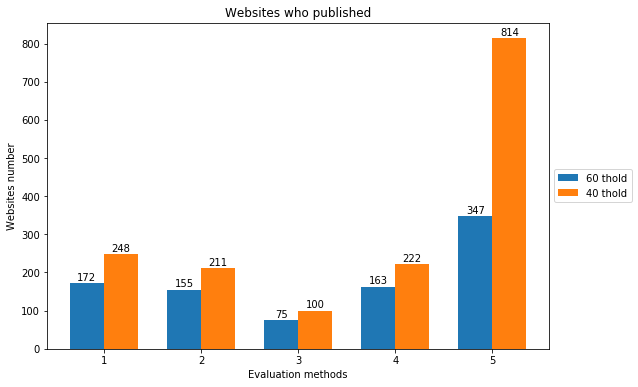

In [5]:
i = 0
generate_plot(i, stp)
plt.show()

### Percentuale siti con pubblicazioni

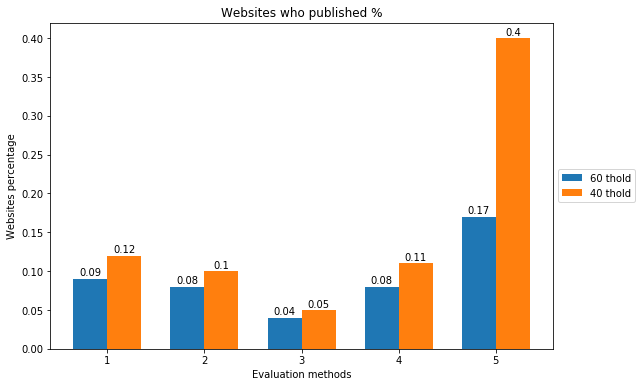

In [6]:
i = 1
generate_plot(i, stp)
plt.show()

### Numero di pdf utili
Si nota che il numero di pdf è sempre maggiore del numero di siti web che pubblicano, questo perchè circa il __18%__ dei siti pubblica un numero che varia da 2 a 4 di pdf che sono ritenuti utili.
Può succedere perchè in alcuni casi sono presenti traduzioni dello stesso file, oppure un riassunto accompagnato dal file completo.

Ritengo che si possa accettare uno scenario del genere per il momento, per poi gestirlo nella successiva parte di analisi semantica del testo, andando ad inserire tutti i file per ogni azienda. 
Sarà poi lo score ad ordinarli per rilevanza.

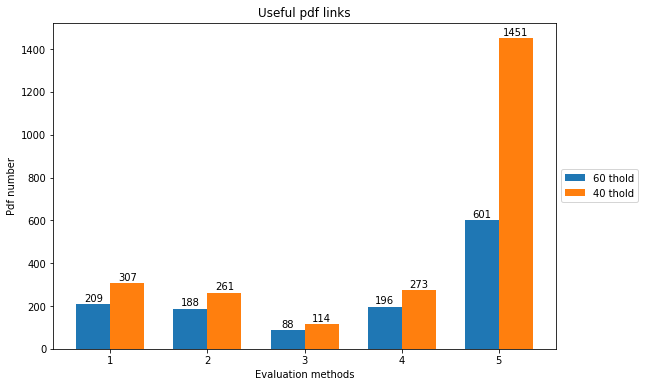

In [7]:
i = 2
generate_plot(i, stp)
plt.show()

### Percentuale di file pdf utili

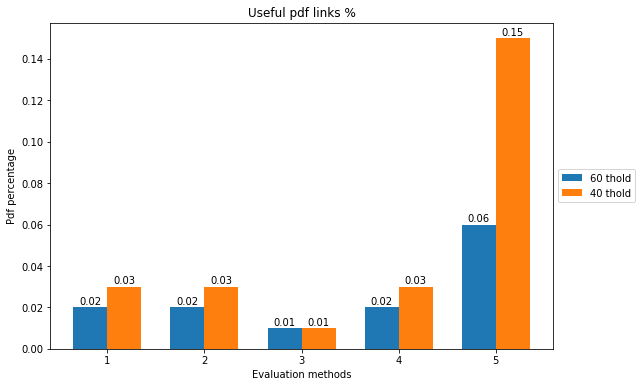

In [8]:
i = 3
generate_plot(i, stp)
plt.show()

### Profondità media dei file

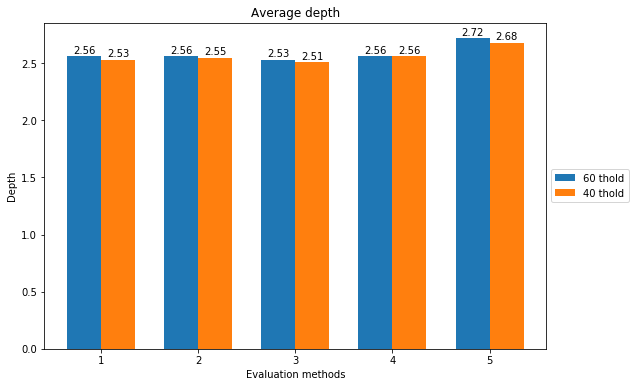

In [9]:
i = 4
generate_plot(i, stp)
plt.show()

### Numero di link presenti in homepage

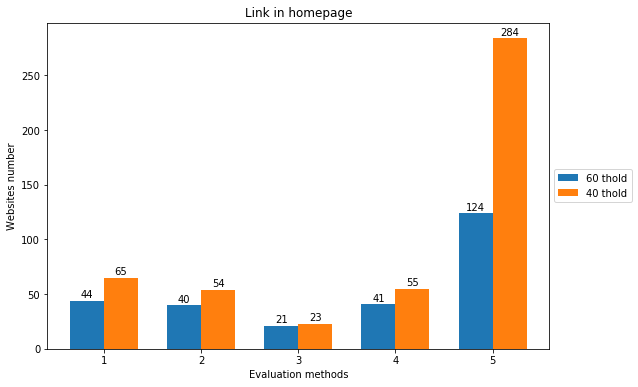

In [10]:
i = 5
generate_plot(i, stp)
plt.show()

# File processing

Dopo aver ottenuto la lista di link ( è stata utilizzata la lista ottenuta dalla prima condizione tra quelle testate, essendo quella che tiene in considerazione più file ) i pdf sono stati scaricati e ne è stato estratto il contenuto.

Purtroppo il valore iniziale di riscontri si è ristretto a causa di problemi con alcuni file pdf, risultati non convertibili o scaricabili.

In [11]:
csv_source = "pdf_ocr/stats.csv"
data = pd.read_csv(csv_source) 
data

,stats,value
0,total files,307
1,file to process,239
2,file processed,218


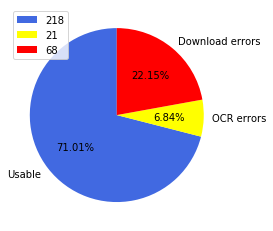

In [12]:
labels = 'Usable', 'OCR errors', 'Download errors'

val = list(data['value'])
sizes = [val[2], val[1] - val[2], val[0] - val[1]]
colors = ['royalblue', 'yellow', 'red']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
plt.legend(sizes, loc="best")

plt.show()

# Indicizzazione Elastic

Ottenuto il contenuto dei file è stato creato un indice elasticsearch, contenente:

1. id atoka dell'azienda
2. nome
3. indirizzo
4. ricavi
5. numero di dipendenti
6. testo contenuto nel documento pdf
7. entità principali del testo
8. tutte le entità del testo
9. url del file pdf
10. score della funzione evaluate sul singolo link

Le informazioni sulle aziende sono state ottenute con Atoka API, mentre quelle sulle entità tramite Dandelion API. 

# Latent Dirichlet Allocation

Per meglio capire gli argomenti trattati nei bilanci è stato usato un modello Latent Dirichlet Allocation.
L'insieme di parole per ogni documento è stato ottenuto dalle entità estratte con Dandelion, esse sono poi state tradotte in inglese poichè i documenti scaricati presentavano lingue differenti.

I modelli sono stati creati provando a considerare sia tutte le entità, sia solo quelle principali.

Sono qui rappresentati due modelli, il primo considera tutte le entità, successivamente solo quelle principali, presenti nei documenti, il secondo si basa su un preprocessing più restrittivo: sono mantenute solo le entità che compaiono in almeno N documenti distinti. 

# Modelli su tutte le entità

A seguire i modelli senza e con vincoli di frequenza sulla lista completa di entità per ogni documento.

## Modello senza vincoli di frequenza - entità complete

Il primo modello non presenta viconli sulle keyword.
### Preprocessing

Il primo passo sta nella preprocessazione dei dati: si parte dalla lista di entità per ogni documento, e si arriva alle strutture necessarie ad allenare il modello, ovvero:
1. dtm_tf : frequency vector
2. tf_vectorizer: count vectorizer contentente il vocabolario estratto dai documenti

In [13]:
csv_input = "elasticsearch_utilities/stats/input_all_entities_en.csv"

data = pd.read_csv(csv_input)
data.head()

,elastic_index,entities
0,1,Secret_Intelligence_Service no Open_Systems_In...
1,2,Sustainability History Scientific_research Sus...
2,3,Board_of_Directors economy Quality_of_life Com...
3,4,Rosia_Montana Value_added Recycling circular_E...
4,5,Financial_statements Product_(economics) Work ...


L'input è preprocessato ottenendo le strutture utili a creare successivamente il modello.

In [14]:
from lda_topic_model import preprocess, print_vocab

dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_all_entities_en.csv")

print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 24646 

Words:

'secret_intelligence_service' : 19536
'open_systems_interconnection' : 15581
'galactic_standard_calendar' : 8997
'autonomous_province_of_trento' : 2103
'natural_resource' : 14809
'gender_' : 9138
'social_sciences' : 20243
'technology' : 21568
'vita' : 23724
'environment_' : 7377
...


### Creazione modello

Il modello viene creato partendo dai dati preprocessati, ovvero dalle entità trovate per ogni documento.

Lo scopo è quello di capire di cosa si parla nella raccola di documenti, andando a trovare degli argomenti formati dalle parole presenti in ogni documento.

In [32]:
%%capture
from sklearn.decomposition import LatentDirichletAllocation

topics = 7

lda = LatentDirichletAllocation(n_components = topics, random_state=0)
lda.fit(dtm_tf)

### Visualizzazione

I topics trovati sono visualizzati con pyLDAvis.

In [33]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.013071  0.021644       1        1  58.426938
0      0.072344  0.033905       2        1  18.549256
1     -0.043656  0.014856       3        1   9.385599
3      0.003568  0.077075       4        1   5.817680
2      0.038072 -0.018817       5        1   5.493247
6     -0.156496 -0.033794       6        1   1.572841
4      0.073096 -0.094868       7        1   0.754438, topic_info=                       Term        Freq       Total Category  logprob  loglift
5                 community  107.000000  107.000000  Default  30.0000  30.0000
34           sustainability  114.000000  114.000000  Default  29.0000  29.0000
35  sustainable_development   95.000000   95.000000  Default  28.0000  28.0000
14                   energy  118.000000  118.000000  Default  27.0000  27.0000
24               management  177.000000  177.000000  Default  26.0000  26.0000
..                      ...         ...         ...      ...      ...      ...
20              information    0.237798  136.500364   Topic7  -5.0062  -1.4657
22               investment    0.237798  106.579199   Topic7  -5.0062  -1.2183
25             organization    0.237798  127.531965   Topic7  -5.0062  -1.3977
23                      law    0.237798  111.295674   Topic7  -5.0062  -1.2616
2                  business    0.237798  123.564209   Topic7  -5.0062  -1.3661

[272 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.659458  behavior
0         2  0.201191  behavior
0         4  0.033532  behavior
0         5  0.089418  behavior
0         7  0.022355  behavior
...     ...       ...       ...
43        2  0.177977     water
43        3  0.168090     water
43        4  0.029663     water
43        5  0.088989     water
43        6  0.049438     water

[231 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 2, 4, 3, 7, 5])

## Modello con vincoli di frequenza - entità complete

Per il modello che segue è stato imposto un vincolo sulla presenza delle keyword in N documenti distinti, in modo da scartare quei termini strettamente legati al settore spefico della singola azienda autrice del bilancio.

A seguire la grandezza del vocabolario in relazione al al valore di N, espresso in percentuale sul totale.
Si nota che anche nel caso in cui N sia molto piccolo in percentuale, la grandezza del vocabolario si riduce di molto rispetto allo scenario mostrato in precedenza.

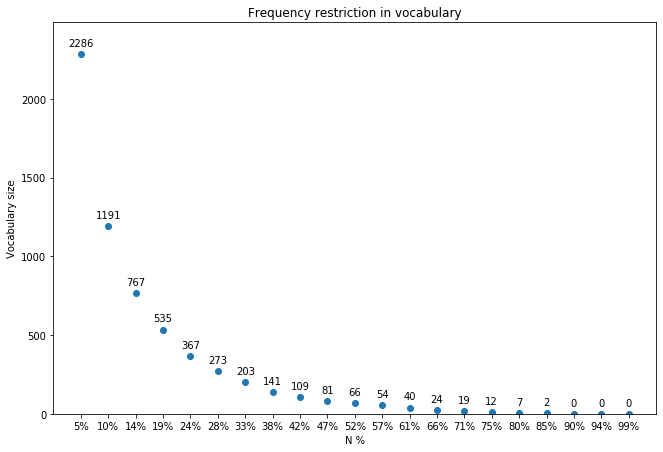

In [17]:
from lda_topic_model import generate_plot

stats_path = "lda_topic_model/data/vocabulary_stats_all_entities.csv"
generate_plot(stats_path)
plt.show()

Il procedimento è lo stesso mostrato per il modello precedente, cambia la funzione di preprocessing che implementa le restrizioni discusse sopra, è stato scelto un numero di topics minori, essendo il vocabolario molto più ristretto.

A seguire il modello che considera solo i termini presenti in almeno il 50% dei documenti.

In [18]:
from lda_topic_model import preprocess_freq_count


perc = 0.5
N = round(170 * perc)

dtm_tf, tf_vectorizer = preprocess_freq_count("elasticsearch_utilities/stats/input_all_entities_en.csv", N)
        
topics = 5
lda = LatentDirichletAllocation(n_components = topics, random_state=0)
lda.fit(dtm_tf)

pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.136750  0.088397       1        1  29.441524
4      0.024558  0.054426       2        1  28.983297
3      0.147117 -0.138664       3        1  22.452125
2     -0.204543 -0.064998       4        1  11.884767
0     -0.103882  0.060838       5        1   7.238288, topic_info=                  Term         Freq        Total Category  logprob  loglift
23                euro  2724.000000  2724.000000  Default  30.0000  30.0000
2   board_of_directors  2358.000000  2358.000000  Default  29.0000  29.0000
56      sustainability  9684.000000  9684.000000  Default  28.0000  28.0000
27             finance  1561.000000  1561.000000  Default  27.0000  27.0000
8              company  5392.000000  5392.000000  Default  26.0000  26.0000
..                 ...          ...          ...      ...      ...      ...
56      sustainability   217.986534  9684.524641   Topic5  -3.4441  -1.1681
58          technology    88.981022  2577.137539   Topic5  -4.3401  -0.7402
28       globalization    56.863289  1220.815833   Topic5  -4.7879  -0.4408
36          investment    60.272192  1676.204046   Topic5  -4.7297  -0.6996
45              policy    56.962129  1684.817777   Topic5  -4.7862  -0.7612

[208 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  0.705057  air_pollution
0         2  0.253851  air_pollution
0         3  0.034053  air_pollution
0         5  0.006965  air_pollution
1         1  0.225290       behavior
...     ...       ...            ...
68        4  0.021126        welfare
68        5  0.024967        welfare
69        1  0.219229          world
69        2  0.164422          world
69        3  0.614624          world

[335 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 3, 1])

# Modelli liste di entità principali

I modelli che seguono sono creati e visualizzati seguendo lo stesso procedimento mostrato sopra, utilizzano però la lista di entità principali.

Lo scopo è quello di isolare i termini ritenuti secondari e dunque ricavare dei modelli più specifici.

## Modello senza vincoli di frequenza - entità principali

Il vocabolario è più ristretto rispetto al modello che considera tutte le entità del testo, è grande meno della metà.

In [19]:
dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_top_entities_en.csv")

print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 10271 

Words:

'secret_intelligence_service' : 8168
'open_systems_interconnection' : 6405
'galactic_standard_calendar' : 3686
'autonomous_province_of_trento' : 785
'natural_resource' : 6082
'gender_' : 3744
'social_sciences' : 8462
'technology' : 9039
'vita' : 9899
'environment_' : 2973
...


In [20]:
topics = 6
lda = LatentDirichletAllocation(n_components = topics, random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.248630 -0.012710       1        1  40.475323
2     -0.007935  0.210904       2        1  33.438312
1     -0.095828  0.068088       3        1   8.652589
4     -0.041474 -0.103866       4        1   7.009964
5      0.004298 -0.093225       5        1   6.520647
0     -0.107691 -0.069190       6        1   3.903165, topic_info=                Term        Freq       Total Category  logprob  loglift
7796           right  165.000000  165.000000  Default  30.0000  30.0000
1245        business  285.000000  285.000000  Default  29.0000  29.0000
4806           italy  149.000000  149.000000  Default  28.0000  28.0000
1018         biology   94.000000   94.000000  Default  27.0000  27.0000
8478        society_   63.000000   63.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
1758  climate_change    2.065653   52.196341   Topic6  -6.7727   0.0138
4200         history    1.908149   28.291291   Topic6  -6.8520   0.5470
3129  european_union    2.012462  110.331852   Topic6  -6.7988  -0.7608
2706         ecology    1.926768   39.889945   Topic6  -6.8423   0.2131
2722       economics    1.955140  400.537445   Topic6  -6.8277  -2.0790

[529 rows x 6 columns], token_table=       Topic      Freq                      Term
term                                            
16         5  0.508358                      1992
27         5  0.508358                  2_rocket
62         5  0.508358                        96
73         5  0.508358                  _citadel
114        5  0.508358                     _soul
...      ...       ...                       ...
10153      2  0.373945                     world
10153      3  0.104705                     world
10153      4  0.029916                     world
10153      5  0.044873                     world
10160      1  0.970018  world_energy_consumption

[973 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 5, 6, 1])

## Modello con vincoli di frequenza - entità principali

Si può notare che l'andamento della grandezza del vocabolario in funzione alla grandezza della restrizione applicata è pressochè uguale al precedente, l'altezza della curva è minore visto la dimensione più ristretta del vocabolario iniziale. 

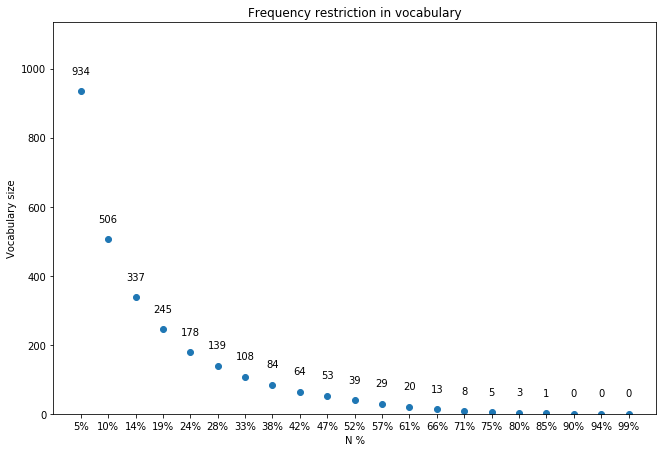

In [24]:
stats_path = "lda_topic_model/data/vocabulary_stats_top_entities.csv"
generate_plot(stats_path)
plt.show()

In [23]:
perc = 0.5
N = round(170 * perc)
        
dtm_tf, tf_vectorizer = preprocess_freq_count("elasticsearch_utilities/stats/input_top_entities_en.csv", N)
        
topics = 5
lda = LatentDirichletAllocation(n_components = topics, random_state=0)
lda.fit(dtm_tf)

pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.005605 -0.002459       1        1  63.510657
2     -0.059478  0.041734       2        1  22.738304
3      0.084393 -0.051923       3        1   6.731963
0     -0.071643 -0.049917       4        1   4.094337
4      0.052334  0.062565       5        1   2.924739, topic_info=              Term        Freq       Total Category  logprob  loglift
24      management  178.000000  178.000000  Default  30.0000  30.0000
13         economy  129.000000  129.000000  Default  29.0000  29.0000
6          company  141.000000  141.000000  Default  28.0000  28.0000
14          energy  117.000000  117.000000  Default  27.0000  27.0000
15            euro  101.000000  101.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
15            euro    2.505259  101.373227   Topic5  -4.0064  -0.1685
10         culture    2.505130  106.168679   Topic5  -4.0065  -0.2147
22      investment    2.502169  107.017309   Topic5  -4.0077  -0.2239
30          safety    2.506120  115.809770   Topic5  -4.0061  -0.3012
17  european_union    2.507240  117.858384   Topic5  -4.0057  -0.3183

[192 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
0         1  0.653759            behavior
0         2  0.293064            behavior
0         3  0.022543            behavior
0         4  0.022543            behavior
1         1  0.727622  board_of_directors
...     ...       ...                 ...
42        4  0.064696    waste_management
42        5  0.010783    waste_management
43        1  0.647137               water
43        2  0.238943               water
43        4  0.119471               water

[191 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1, 5])